# DS 424 — Lab Final (Topic B)
_Auto-generated: 2025-08-20 12:00:18_

## Tiny Image Augmentation + CNN (3 classes: 0,1,2)
We load three 32×32 grayscale seed images (`zero_0.png`, `one_0.png`, `two_0.png`), show them in a 1×3 grid, build a mini dataset via augmentation (≥20 per class; hold out 12 for testing), train a compact CNN (two optimizers × two learning rates, ≤25 epochs), plot train vs val accuracy, and evaluate on the held-out test set with accuracy/precision/recall/F1 (macro) and a confusion matrix, followed by a short conclusion.

> If the PNGs are missing, this notebook will auto-create simple digit-like seeds so it runs end-to-end.

In [12]:
%pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.8/39.0 MB 6.7 MB/s eta 0:00:06
    --------------------------------------- 0.8/39.0 MB 6.7 MB/s eta 0:00:06
   - -------------------------------------- 1.0/39.0 MB 2.4 MB/s eta 0:00:16
   - -------------------------------------- 1.6/39.0 MB 2.1 MB/s eta 0:00:18
   -- ------------------------------------- 2.1/39.0 MB 2.0 MB/s eta 0:00:19
   -- ------------------------------------- 2.4/39.0 MB 1.9 MB/s eta 0:00:20
   -- ------------------------------------- 2.9/39.0 MB 2.0 MB/s eta 0:00:19
   --- ------------------------------------ 3.1/39.0 MB 2.0 MB/s eta 0:00:19
   --- ------------------------------------ 3.7/39.0 MB 1.9 MB/s eta 0:00:19
   ---- ----------------------------------- 3.9/39.0 MB 1.9 MB/s eta 0:00:19
   ---- ----------------------------------- 4.5/39.0 MB 1.9 MB/s eta 0:00:18
   ---- ----------------------------------- 4.7/39.0 MB 1.9 MB/s eta 0:00:18
   ---


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import os, numpy as np, matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
np.random.seed(123)
tf.random.set_seed(123)


### 1) Load & Show seed images (1×3 grid)

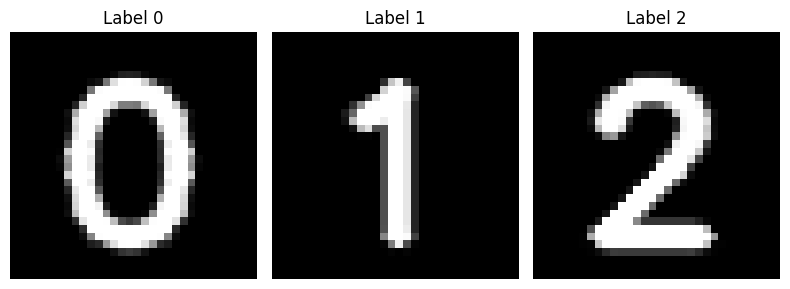

In [15]:
SEED_DIR='.'
seed_files=[('zero_0.png',0),('one_0.png',1),('two_0.png',2)]
def ensure_seed_images():
    for fname, digit in seed_files:
        path=os.path.join(SEED_DIR,fname)
        if not os.path.exists(path):
            img=np.zeros((32,32),dtype=np.uint8)
            (w,h),baseline=cv2.getTextSize(str(digit),cv2.FONT_HERSHEY_SIMPLEX,0.9,2)
            x=(32-w)//2; y=(32+h)//2
            cv2.putText(img,str(digit),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.9,255,2,cv2.LINE_AA)
            cv2.imwrite(path,img)
            print('[INFO] Created seed:', path)
ensure_seed_images()

imgs=[]; labels=[]
for fname,lab in seed_files:
    img=cv2.imread(os.path.join(SEED_DIR,fname),cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(fname)
    img=cv2.resize(img,(32,32))
    imgs.append(img); labels.append(lab)
imgs=np.array(imgs); labels=np.array(labels)
plt.figure(figsize=(8,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(imgs[i],cmap='gray')
    plt.title(f'Label {labels[i]}'); plt.axis('off')
plt.tight_layout(); plt.show()

### 2) Augmentation — Build mini-dataset (≥20/class) & hold out test

In [ ]:
augment=keras.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.RandomRotation(0.08),
    keras.layers.RandomTranslation(0.09,0.09),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1)
])
def add_noise(x,std=0.08):
    noise=tf.random.normal(shape=tf.shape(x),mean=0.0,stddev=std,dtype=x.dtype)
    return tf.clip_by_value(x+noise,0.0,1.0)
def make_dataset(per_class_train=28, per_class_test=4):
    Xtr,Ytr,Xte,Yte=[],[],[],[]
    for idx,(fname,lab) in enumerate(seed_files):
        img=imgs[idx].astype('float32')/255.0
        img=np.expand_dims(img,-1)
        for _ in range(per_class_train):
            x=tf.convert_to_tensor(img[None,...])
            x=augment(x,training=True); x=add_noise(x)
            Xtr.append(x.numpy()[0]); Ytr.append(lab)
        for _ in range(per_class_test):
            x=tf.convert_to_tensor(img[None,...])
            x=augment(x,training=True); x=add_noise(x)
            Xte.append(x.numpy()[0]); Yte.append(lab)
        Xtr.append(img); Ytr.append(lab)
    Xtr=np.array(Xtr,'float32'); Ytr=np.array(Ytr,'int32')
    Xte=np.array(Xte,'float32'); Yte=np.array(Yte,'int32')
    print('Train:',Xtr.shape,' Test:',Xte.shape)
    return Xtr,Ytr,Xte,Yte
X_train,y_train,X_test,y_test=make_dataset()

UnboundLocalError: cannot access local variable 'np' where it is not associated with a value

### 3) CNN — Try two optimizers × two LRs (≤25 epochs)

In [ ]:
def build_cnn(input_shape=(32,32,1), lr=1e-3, optimizer_name='adam', n_classes=3):
    model=keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32,3,activation='relu',padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(32,activation='relu'),
        keras.layers.Dense(n_classes,activation='softmax')
    ])
    opt=keras.optimizers.Adam(lr) if optimizer_name.lower()=='adam' else keras.optimizers.SGD(lr,momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
configs=[('adam',1e-3),('adam',1e-2),('sgd',1e-3),('sgd',1e-2)]
evals=[]
for opt_name,lr in configs:
    model=build_cnn(lr=lr,optimizer_name=opt_name)
    h=model.fit(X_train,y_train,validation_split=0.2,epochs=25,batch_size=16,verbose=0)
    proba=model.predict(X_test,verbose=0)
    y_pred=np.argmax(proba,axis=1)
    acc=accuracy_score(y_test,y_pred)
    prec,rec,f1,_=precision_recall_fscore_support(y_test,y_pred,average='macro',zero_division=0)
    cm=confusion_matrix(y_test,y_pred,labels=[0,1,2])
    evals.append({'optimizer':opt_name,'lr':lr,'accuracy':acc,'precision_macro':prec,'recall_macro':rec,'f1_macro':f1,'cm':cm,'history':h.history})
import pandas as pd
evals_df=pd.DataFrame([{k:v for k,v in r.items() if k not in ('cm','history')} for r in evals])
display(evals_df.sort_values(['f1_macro','accuracy'],ascending=False))
best_idx=evals_df.sort_values(['f1_macro','accuracy'],ascending=False).index[0]
bestB=evals[int(best_idx)]
print(f"Best: optimizer={bestB['optimizer']}  lr={bestB['lr']}")
print('Test: ACC={:.3f}  PREC={:.3f}  REC={:.3f}  F1={:.3f}'.format(bestB['accuracy'],bestB['precision_macro'],bestB['recall_macro'],bestB['f1_macro']))

plt.figure(figsize=(5,3))
plt.plot(bestB['history']['accuracy'],label='train_acc')
plt.plot(bestB['history']['val_accuracy'],label='val_acc')
plt.title('Training vs Validation Accuracy (Best Config)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(4,4))
plt.imshow(bestB['cm'], interpolation='nearest')
plt.title('Confusion Matrix (Best Config)')
plt.colorbar();
ticks=np.arange(3); plt.xticks(ticks,['0','1','2']); plt.yticks(ticks,['0','1','2'])
for i in range(3):
    for j in range(3):
        plt.text(j,i,int(bestB['cm'][i,j]),ha='center',va='center')
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout(); plt.show()

### 4) Conclusion (3–5 lines)

In [ ]:
hist=bestB['history']
train_acc_last=hist['accuracy'][-1]
val_acc_last=hist['val_accuracy'][-1]
gap=train_acc_last-val_acc_last
fit_comment='Possible overfitting.' if gap>0.03 else 'No strong signs of overfitting.'
print(
    f"Best config: {bestB['optimizer'].upper()} @ lr={bestB['lr']}. "
    f"Test ACC={bestB['accuracy']:.3f}, PREC={bestB['precision_macro']:.3f}, REC={bestB['recall_macro']:.3f}, F1={bestB['f1_macro']:.3f}. "
    f"Val acc {val_acc_last:.3f} vs train {train_acc_last:.3f}. {fit_comment}"
)